In [69]:
from model.model import ConditionalVAE
from model.dataset import TabularDataset
from model.utils.visualization import PCA_plot, PCA_plot_rare_on_top
from model.utils.optimization import *
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from collections import Counter
from matplotlib.cm import get_cmap
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, balanced_accuracy_score

from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch

from imblearn.over_sampling import (
	SMOTE,
	ADASYN,
	BorderlineSMOTE,
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
with open('data.pickle', 'rb') as fh:
	data_mapper = pickle.load(fh)
splits = pd.read_csv('data_splits.csv')

data_keys = []
for split_name in splits:
	for idx in range(31):
		data_keys.append(f"{idx}_{split_name}")

In [3]:
data_key = data_keys[0]
x_train = data_mapper[data_key]['x_train'] 
y_train = data_mapper[data_key]['y_train']
x_validation = data_mapper[data_key]['x_validation'] 
y_validation = data_mapper[data_key]['y_validation']
x_test = data_mapper[data_key]['x_test'] 
y_test = data_mapper[data_key]['y_test']

x_prior = np.concatenate((x_train, x_validation), axis=0)
y_prior = np.concatenate((y_train, y_validation), axis=0)

x_smote, y_smote = SMOTE().fit_resample(x_prior, y_prior)

minority_label = pd.DataFrame(y_train).value_counts().argmin()
minority_indices = np.where(y_train==minority_label)[0]
minority_features = x_train[minority_indices]
minority_labels = y_train[minority_indices]

num_features = x_prior[0].shape[0]


In [ ]:
h1 = 15
h2 = 18
latent_dim = 20

cvae = ConditionalVAE(
	input_dim=num_features, 
	h1=h1,
	h2 = h2,
	latent_dim=latent_dim).to(device)

In [ ]:
epochs = 900
batch_size = 32
lr = 1e-3
beta = 0.8

data = TabularDataset(x_smote, x_smote, y_smote)
loader = DataLoader(data, batch_size=batch_size, shuffle=True)

cvae.train()
opt = optim.Adam(cvae.parameters(), lr=lr)
for epoch in range(1, epochs + 1):
	running = 0
	for encode_in, decode_comp, label in loader:
		xb = encode_in.float().to(device)
		yb = decode_comp.float().to(device)
		label = label.float().to(device)

		# xb_mask = mask_features(xb)
		
		recon, mu, logvar = cvae(xb, label)
		# recon_loss = nn.MSELoss()(recon, xb)
		# kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
		# loss = recon_loss + (kl_div*beta)
		recon_loss = nn.MSELoss(reduction='sum')(recon, xb)
		kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
		loss = (recon_loss + beta * kl_div) / xb.size(0)   # per-batch average

		opt.zero_grad()
		loss.backward()
		opt.step()

		running += loss.item()
	
	if epoch % 5 == 0 or epoch == epochs:
		print(f"Epoch {epoch:03d} | loss: {running / len(loader):.4f}")

Epoch 005 | loss: 3.3382
Epoch 010 | loss: 2.9587
Epoch 015 | loss: 2.4696
Epoch 020 | loss: 2.3041
Epoch 025 | loss: 2.2211
Epoch 030 | loss: 2.1552
Epoch 035 | loss: 2.1383
Epoch 040 | loss: 2.1444
Epoch 045 | loss: 2.1326
Epoch 050 | loss: 2.1159
Epoch 055 | loss: 2.1350
Epoch 060 | loss: 2.1046
Epoch 065 | loss: 2.1009
Epoch 070 | loss: 2.0934
Epoch 075 | loss: 2.0903
Epoch 080 | loss: 2.1075
Epoch 085 | loss: 2.1000
Epoch 090 | loss: 2.0941
Epoch 095 | loss: 2.0963
Epoch 100 | loss: 2.0388
Epoch 105 | loss: 2.0183
Epoch 110 | loss: 1.9773
Epoch 115 | loss: 1.9618
Epoch 120 | loss: 1.9523
Epoch 125 | loss: 1.9367
Epoch 130 | loss: 1.9479
Epoch 135 | loss: 1.9497
Epoch 140 | loss: 1.9233
Epoch 145 | loss: 1.9269
Epoch 150 | loss: 1.9127
Epoch 155 | loss: 1.9455
Epoch 160 | loss: 1.9102
Epoch 165 | loss: 1.9272
Epoch 170 | loss: 1.9110
Epoch 175 | loss: 1.9016
Epoch 180 | loss: 1.9087
Epoch 185 | loss: 1.9312
Epoch 190 | loss: 1.9120
Epoch 195 | loss: 1.9084
Epoch 200 | loss: 1.9003


In [ ]:
nearest_neighbours = NearestNeighbors(n_neighbors=5, metric="euclidean").fit(x_smote)
dist, idx = nearest_neighbours.kneighbors(x_smote)

dist = dist[:, 1:]          # shape: (n_samples, k)
idx  = idx[:, 1:]           # shape: (n_samples, k)

knn_features = [x_smote[row_idx] for row_idx in idx]
knn_labels = [y_smote[row_idx] for row_idx in idx]

input_set = []
recon_set = []
labels = []
for s_idx, sample in enumerate(x_smote):
	
	for n_idx, neighbouring_sample in enumerate(knn_features[s_idx]):
		if y_smote[s_idx] == knn_labels[s_idx][n_idx]:
			input_set.append(sample)
			recon_set.append(neighbouring_sample)
			labels.append(y_smote[s_idx])

In [ ]:
def mask_features(x, min_mask: int = 1, max_mask: int = 3):
	x_masked = x.clone()
	for i in range(x.size(0)):
		k = torch.randint(min_mask, max_mask + 1, (1,)).item()
		idx = torch.randperm(x.size(1))[:k]
		x_masked[i, idx] = 0
	return x_masked

In [ ]:
epochs = 900
batch_size = 32
lr = 1e-3
beta = 0.8

h1 = 15
h2 = 18
latent_dim = 20

data = TabularDataset(
	np.array(input_set), 
	np.array(recon_set), 
	np.array(labels)
)
loader = DataLoader(data, batch_size=batch_size, shuffle=True)

cvae.train()
opt = optim.Adam(cvae.parameters(), lr=lr)
for epoch in range(1, epochs + 1):
	running = 0
	for encode_in, decode_comp, label in loader:
		xb = encode_in.float().to(device)
		xb_masked = mask_features(xb)
		yb = decode_comp.float().to(device)
		label = label.float().to(device)
		# xb_mask = mask_features(xb)

		recon, mu, logvar = cvae(xb_masked, label)
		# recon_loss = nn.MSELoss()(recon, xb)
		# kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
		# loss = recon_loss + (kl_div*beta)
		recon_loss = nn.MSELoss(reduction='sum')(recon, yb)
		kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
		loss = (recon_loss + beta * kl_div) / xb.size(0)   # per-batch average

		opt.zero_grad()
		loss.backward()
		opt.step()

		running += loss.item()

	if epoch % 5 == 0 or epoch == epochs:
		print(f"Epoch {epoch:03d} | loss: {running / len(loader):.4f}")

Epoch 005 | loss: 2.0678
Epoch 010 | loss: 1.9811
Epoch 015 | loss: 1.9487
Epoch 020 | loss: 1.9353
Epoch 025 | loss: 1.9243
Epoch 030 | loss: 1.9112
Epoch 035 | loss: 1.9108
Epoch 040 | loss: 1.9017
Epoch 045 | loss: 1.9047
Epoch 050 | loss: 1.9009
Epoch 055 | loss: 1.9081
Epoch 060 | loss: 1.9021
Epoch 065 | loss: 1.9044
Epoch 070 | loss: 1.8963
Epoch 075 | loss: 1.9014
Epoch 080 | loss: 1.8900
Epoch 085 | loss: 1.9024
Epoch 090 | loss: 1.8942
Epoch 095 | loss: 1.8934
Epoch 100 | loss: 1.8925
Epoch 105 | loss: 1.8996
Epoch 110 | loss: 1.8963
Epoch 115 | loss: 1.8975
Epoch 120 | loss: 1.8842
Epoch 125 | loss: 1.9004
Epoch 130 | loss: 1.8950
Epoch 135 | loss: 1.8820
Epoch 140 | loss: 1.8919
Epoch 145 | loss: 1.8934
Epoch 150 | loss: 1.8825
Epoch 155 | loss: 1.8813
Epoch 160 | loss: 1.8806
Epoch 165 | loss: 1.8778
Epoch 170 | loss: 1.8970
Epoch 175 | loss: 1.8861
Epoch 180 | loss: 1.8770
Epoch 185 | loss: 1.8951
Epoch 190 | loss: 1.8930
Epoch 195 | loss: 1.8637
Epoch 200 | loss: 1.8883


C:\Users\RjKim\AppData\Local\Temp\ipykernel_36928\3605402553.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette        = get_cmap('coolwarm', len(labels))      # discrete palette


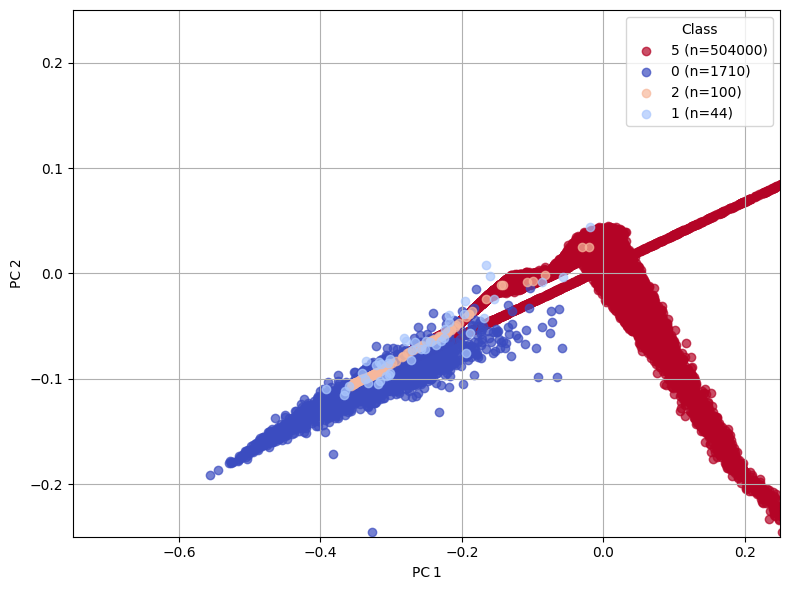

In [67]:
num_gen = 100
z = torch.randn(num_gen, latent_dim, device=device)
label_ones = torch.ones(num_gen, device=device)
gen_labels = torch.tensor([2] * num_gen)
# print(gen_labels)
cvae.eval()
with torch.no_grad():
	x_gen = cvae.decode(z, label_ones)  

x_cvae = np.concatenate((x_prior, x_gen), axis=0)
y_cvae = np.concatenate((y_prior, label_ones), axis=0)

# xx, yy = SMOTE().fit_resample(x_prior, y_prior)
xx_prior = np.concatenate((x_prior, x_gen), axis=0)
yy_prior = np.concatenate((y_prior, gen_labels), axis=0)

xx_prior = np.concatenate((xx_prior, synthetic_X_DECODE), axis=0)
yy_prior = np.concatenate((yy_prior, test_labels), axis=0)

# --- PCA -------------------------------------------------------------
X_scaled = StandardScaler().fit_transform(xx_prior)
X_pca    = PCA(n_components=2).fit_transform(X_scaled)

# --- colour palette --------------------------------------------------
labels         = np.unique(yy_prior)
palette        = get_cmap('coolwarm', len(labels))      # discrete palette
colour_by_lbl  = {lbl: palette(i) for i, lbl in enumerate(labels)}

# --- count class frequencies & plot ---------------------------------
counts         = Counter(yy_prior)
ordered_labels = sorted(counts, key=counts.get, reverse=True)  # rare last

plt.figure(figsize=(8, 6))
for z, lbl in enumerate(ordered_labels):
	mask = yy_prior == lbl
	plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
				color=colour_by_lbl[lbl], alpha=0.7,
				label=f'{lbl} (n={counts[lbl]})', zorder=z)

plt.xlabel('PC 1');  plt.ylabel('PC 2');  plt.grid(True)
plt.xlim((-.75, .25))
plt.ylim((-.25, .25))
plt.legend(title='Class')
plt.tight_layout();  plt.show()

In [26]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(x_prior, y_prior)
y_pred = model.predict(x_test)

# print(classification_report(y_test, y_pred))
roc_auc_score(y_test, y_pred), accuracy_score(y_test, y_pred), balanced_accuracy_score(y_test, y_pred)

(np.float64(0.5357142857142857),
 0.9777397260273972,
 np.float64(0.5357142857142857))

In [27]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(x_cvae, y_cvae)
y_pred = model.predict(x_test)

# print(classification_report(y_test, y_pred))
roc_auc_score(y_test, y_pred), accuracy_score(y_test, y_pred), balanced_accuracy_score(y_test, y_pred)

(np.float64(0.7046365914786968),
 0.9674657534246576,
 np.float64(0.7046365914786967))

In [29]:
# for sampler 
model = KNeighborsClassifier(n_neighbors=5)
model.fit(x_smote, y_smote)
y_pred = model.predict(x_test)

# print(classification_report(y_test, y_pred))
roc_auc_score(y_test, y_pred), accuracy_score(y_test, y_pred), balanced_accuracy_score(y_test, y_pred)

(np.float64(0.7105263157894737),
 0.910958904109589,
 np.float64(0.7105263157894737))

In [ ]:
feature_variance = np.var(x_prior, axis=0)
feature_mins = np.min(x_prior, axis=0)
feature_maxs = np.max(x_prior, axis=0)

feature_grids = []
for idx, curr_variance in enumerate(feature_variance):
	curr_min = feature_mins[idx]
	curr_max = feature_maxs[idx]
	feature_space = np.arange(curr_min-curr_variance, curr_max+curr_variance, curr_variance*2)

	
feature_grids = np.array(feature_grids)

mesh = np.meshgrid(*feature_grids, indexing='ij')
synthetic_X = np.stack(mesh, -1).reshape(-1, len(feature_grids))


ValueError: need at least one array to stack

In [ ]:
import numpy as np
from itertools import product          # ‑‑ memory‑efficient iterator

# --- grids for each feature --------------------------------------------
feature_grids = []
for idx, var in enumerate(feature_variance):
	lo  = feature_mins[idx] - var      # lower bound  (min – variance)
	hi  = feature_maxs[idx] + var      # upper bound  (max + variance)
	step = var * 2 or 1e-8             # avoid step == 0 if var == 0
	grid = np.arange(lo, hi + step, step)
	feature_grids.append(grid)

# --- Cartesian product  -------------------------------------------------
# itertools.product is lazy ⇒ less memory than meshgrid on huge spaces
synthetic_X = np.fromiter(
	(val for combo in product(*feature_grids) for val in combo),
	dtype=float
).reshape(-1, len(feature_grids))

print(f"{synthetic_X.shape[0]:,} synthetic rows × {synthetic_X.shape[1]} features")


504,000 synthetic rows × 7 features


In [58]:
x_prior[0].dtype

dtype('float64')

In [ ]:
styt

dtype('float64')

In [60]:
test_labels = torch.tensor([minority_label] * synthetic_X.shape[0])

cvae.eval()
with torch.no_grad():
	xb = torch.tensor(synthetic_X).float().to(device)
	mu, logvar = cvae.encode(xb)
	z = cvae.reparameterize(mu, logvar)
	synthetic_X_DECODE = cvae.decode(z, test_labels)  

In [ ]:
synthetic_X_DECODE.shape
test_labels = torch.tensor([5] * synthetic_X.shape[0])



In [ ]:
problem = NSGA_II_Filter(
	np.concatenate((x_prior, synthetic_X_DECODE), axis=0), 
    np.concatenate((y_prior, test_labels), axis=0), 
	x_validation, y_validation,
)
algorithm = NSGA2(
	pop_size=500, 
	sampling=DiverseSampling(), 
	crossover=HUX(), 
	mutation=BitflipMutation(), 
	eliminate_duplicates=True
)
result = minimize(
	problem, 
	algorithm, 
	('n_gen', 100),
	save_history=False,
)